In [22]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import gdal
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection


In [2]:
# set plot default 
# set font
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.size'] = 13.0
mpl.rcParams['font.family'] = 'sans-serif'#'sans-serif', 'monospace'
# set axes
mpl.rcParams['axes.titlesize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'large'
# legend
mpl.rcParams['legend.fontsize'] = 'large'
# figure
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
#mpl.rcParams['figure.dpi'] = 90
mpl.rcParams['figure.titlesize'] = 'xx-large'
#mpl.rcParams['savefig.dpi'] = 90
mpl.rcParams['savefig.bbox'] = 'standard' # 'tight' is incompatible with pipe-based animation
mpl.rcParams['savefig.transparent'] = 'False' 


In [3]:
tfreeze = 273.16
tzero   = 273.15


In [24]:
class SummaPlot:
    
    # some constant parameters
    _VAR_NAME_HEIGHT = 'iLayerHeight'
    _LAYER_DIM = {
        "midSnowAndTime" : ("midSnowStartIndex", 'nSnow') ,
        "midSoilAndTime" : ("midSoilStartIndex", 'nSoil') ,
        "midTotoAndTime" : ("midTotoStartIndex", 'nLayers') ,
        "ifcSnowAndTime" : ("ifcSnowStartIndex", 'nSnow') ,
        "ifcSoilAndTime" : ("ifcSoilStartIndex", 'nSoil') ,
        "ifcTotoAndTime" : ("ifcTotoStartIndex", 'nLayers') ,
        }
    _NVERT = 4
    _NCOOR = 2 
    
    def __init__(self,  ds, *args, **kwargs):   
        if type(ds) == xr.Dataset:
            self.ds = ds
        else:
            raise TypeError('must provide xarray.Dataset')

        
    def _add_block(x1, x2, y1, y2):
        """
        add the verts (four points) of a layer of a column
        """
        block_pts = np.empty([SummaPlot._NVERT, SummaPlot._NCOOR])  # allocate space is faster than np.array([...])
        block_pts[0, 0] = x1; block_pts[0, 1] = y1 # point 1
        block_pts[1, 0] = x2; block_pts[1, 1] = y1 # point 2
        block_pts[2, 0] = x2; block_pts[2, 1] = y2 # point 3
        block_pts[3, 0] = x1; block_pts[3, 1] = y2 # point 4
        return block_pts
 
   
    def _add_column(time1, time2, heights):
        """
        add the vertices of a column
        """
        n = heights.shape[0] - 1
        verts = np.array([ SummaPlot._add_block(time1, time2, heights[i], heights[i + 1]) for i in range(n) ])
        return verts    
    
    
    def date2num4plt(times):
        '''
        convert the netcdftime stmp to the datetime series 
        that recognized by matplotlib        
        '''
        return mpl.dates.date2num([ pd.Timestamp(t).to_datetime() for t in times.values ])

 
    def get_layer_sindex(ds, var_name):
        '''
        get the starting layer index
        '''
        dims = ds[var_name].dims
        for k in SummaPlot._LAYER_DIM.keys():
            if k in dims:
                return ds[SummaPlot._LAYER_DIM[k][0]] - 1
    
    def _split_time_layer(ds, var_name):
        '''
        split the ragged time layer dimemsion
        '''
        # find the ragged_dim_name
        ragged_dim_name = ''
        dims = list(ds[var_name].dims)
        for k in SummaPlot._LAYER_DIM.keys():
            if k in dims:
                ragged_dim_name = k
        if ragged_dim_name == '':
            raise KeyError(var_name + ' is not a ragged variable')
        addlayer = 1 if ragged_dim_name[0] == 'i' else 0
        max_time = ds.dims['time']
        max_hru = ds.dims['hru']
        idx_ragged = ds[SummaPlot._LAYER_DIM[ragged_dim_name][0]].values
        nlayer = ds[SummaPlot._LAYER_DIM[ragged_dim_name][1]].values
        max_layer = nlayer.max() + addlayer
        #idx_ragged
        # split mSnow
        
        vals = np.empty([max_time, max_hru, max_layer])
        vals.fill(np.nan)
        val_ori = ds[var_name].values
        #for v in ds.data_vars:
            
        for itime in range(ds.dims['time']):
            for ihru in range(ds.dims['hru']):
                vals[itime, ihru, np.arange(nlayer[itime, ihru] + addlayer)] = val_ori[idx_ragged[itime, ihru] - 1 + np.arange(nlayer[itime, ihru] + addlayer), ihru]
                
        return xr.Dataset({var_name: (['time', 'hru', ragged_dim_name[0] + 'layer'], vals), 
                          'nLayers': (['time', 'hru'], nlayer)})
        
    
    def _squeeze(ds, var_name, desired_dim, other_index):
        """
        Reduce the variable in the input DataSet to the desired dimension
        
        Arguments
        ----------
        ds (xarray.Dataset): required
            An xarray Dataset
        var_name (str): required
            Name of the variable whose dimension to be reduced
        desired_dim (str or list-liked): required
            Name of the desired dimension
        other_index (list-like or integer): required
            Indices to be used for other dimension, 
            followed the dimension order of the dataset
            
        Returns
        -------
        ds_slim (number): 
            The average of a and b, computed using 0.5*(a + b)
        Exceptions
        -------
        
        Example
        -------
        >>> ds = xarray.Dataset({'v1': (['x', 'y', 'z'], numpy.random.randn(2, 2, 3)),
        ...                      'v2': (['x', 'y'], numpy.random.randn(2, 2))})
        >>> ds
        <xarray.Dataset>
        Dimensions:  (x: 2, y: 2, z: 3)
        Coordinates:
          * x        (x) int64 0 1
          * y        (y) int64 0 1
          * z        (z) int64 0 1 2
        Data variables:
            v2       (x, y) float64 -0.8387 1.236 -1.7 1.118
            v1       (x, y, z) float64 -1.482 1.793 -0.311 -0.7124 -1.172 -1.274 ...
        >>> _squeeze(ds, 'v1', 'z', (0, 0))
        <xarray.Dataset>
        Dimensions:  (z: 3)
        Coordinates:
            x        int64 0
            y        int64 0
          * z        (z) int64 0 1 2
        Data variables:
            v2       float64 -0.8387
            v1       (z) float64 -1.482 1.793 -0.311
        
        """
        
        # check if the desired is a layer variable
        
 
        dims = list(ds[var_name].dims)
        # get the nested dim (layer + time)
        for k in SummaPlot._LAYER_DIM.keys():
            if k in dims:
                raise TypeError('Could not squeeze the ragged time-layer dimension')
        
        #
        if type(desired_dim) == str:
            dims.remove(desired_dim)
        else:
            for d in desired_dim:
                dims.remove(d)
        # squeeze
        if type(other_index) == int:
            other_index = [other_index]
        others = {d:i for d, i in zip(dims, other_index)}  
        return ds[others]
            
        


    # TODO: plot the map showing spatial distribution of a variable   
    def plot2d_map(self, var_name, hru_shp, val_offset=0.0, val_range=None, idx_other=0, ax=None, cmap=None, vmin=None, vmax=None, figsize=None):
        '''
        print 2d map
        idx_other: (int or list-like int)
            the indices other than hru for the desired variable
        '''
        ds = self.ds.copy()
        ds = SummaPlot._squeeze(ds, var_name, 'hru', idx_other)
        ds = ds[var_name].values
        if val_range != None:
            ds[(ds<val_range[0]) | (ds>val_range[1])] = np.nan
        gdf = None
        if type(hru_shp) == str:
            # open the shapefile
            gdf = gpd.GeoDataFrame.from_file(hru_shp)
        elif type(hru_shp) == gpd.GeoDataFrame:
            gdf = hru_shp
        else:
            raise TypeError('hru_shp must be the path of the HRU shapefile or an GeoDataFrame object')
        # it must have the hru dimemsion
        gdf['values'] = ds
        if val_range != None:
            gdf = gdf[(gdf['values']>=val_range[0]) & (gdf['values']<=val_range[1])]
        #print(gdf.describe())
        ax = gdf.plot(ax=ax, column='values', cmap=cmap, vmin=vmin, vmax=vmax, linewidth=0.0, alpha=1.0, figsize=figsize, zorder=999)
        return ax
    
    
    def plot2d_fast_map(self, var_name, idx_grid, val_offset=0.0, val_range=None, idx_other=0, ax=None, figsize=None):
        '''
        
        to make a hru index grid:
            gdal_rasterize -a 'order_id' -l 'columbia_hru_output_geo' -te $xmin $ymin $xmax $ymax -tr $dx $dy -ot 'UInt32' 'columbia_hru_output_geo.shp' 'hru_idx.tif
        '''
        
        # it must have the hru dimemsion
        ds = self.ds.copy()
        ds = SummaPlot._squeeze(ds, var_name, 'hru', idx_other)
        ds = ds[var_name].values
        if val_range != None:
            ds[(ds<val_range[0]) | (ds>val_range[1])] = np.nan
        hru_idx = None
        if type(idx_grid) == str:
            # open the shapefile
            hru_idx = gdal.Open(idx_grid).ReadAsArray()
        elif type(idx_grid) == gdal.Dataset:
            hru_idx = idx_grid.ReadAsArray()
        else:
            raise TypeError('hru_shp must be the path of the HRU shapefile or an GeoDataFrame object')
            
        # it must have the hru dimemsion
        mask = (hru_idx == 0)
        val_arr = np.where(mask, np.nan, ds[hru_idx.astype(np.int)-1])
        
        if ax == None:
            fig, ax = plt.subplots(figsize=figsize)        
        img = ax.imshow(val_arr)
        fig.colorbar(img, ax=ax)
        pass
    
    # TODO: sdsd
    def plot_curve(self, var_name, new_name=None,freq=1, val_mult=1.0, val_offset=0.0, val_range=None, 
                   x_axis='time', idx_other=0, xlim=None, ylim=None, logx=False, logy=False, ax=None,
                   figsize=(12, 6), legend=True, legend_title='', table=False,
                   title='', secondary_y=False, ylab='', rylab='', **kwargs): 
        """
        Reduce the variable in the input DataSet to the desired dimension
        
        Arguments
        ----------
        ds (xarray.Dataset): required
            An xarray Dataset
        var_name (str): required
            Name of the variable to be plotted
        new_name (str): optional, default=None
            Name used to label the variable in the Legend
        other_index (list-like or integer): required
            Indices to be used for other dimension, 
            followed the dimension order of the dataset
            
        Returns
        -------
        ds_slim (number): 
            The average of a and b, computed using 0.5*(a + b)
        Exceptions
        -------
        
        Example
        -------
        >>> ds = xarray.Dataset({'v1': (['x', 'y', 'z'], numpy.random.randn(2, 2, 3)),
        ...                      'v2': (['x', 'y'], numpy.random.randn(2, 2))})
        >>> ds
        <xarray.Dataset>
        Dimensions:  (x: 2, y: 2, z: 3)
        Coordinates:
          * x        (x) int64 0 1
          * y        (y) int64 0 1
          * z        (z) int64 0 1 2
        Data variables:
            v2       (x, y) float64 -0.8387 1.236 -1.7 1.118
            v1       (x, y, z) float64 -1.482 1.793 -0.311 -0.7124 -1.172 -1.274 ...
        >>> _squeeze(ds, 'v1', 'z', (0, 0))
        <xarray.Dataset>
        Dimensions:  (z: 3)
        Coordinates:
            x        int64 0
            y        int64 0
          * z        (z) int64 0 1 2
        Data variables:
            v2       float64 -0.8387
            v1       (z) float64 -1.482 1.793 -0.311
        
        """
        
        # get the dimension names
        ds = SummaPlot._squeeze(self.ds, var_name, x_axis, idx_other)  
              
        df = ds[var_name].to_dataframe()[var_name]
        
        # plot
        if ax == None:
            fig, ax = plt.subplots(figsize=figsize)
            
        # apply transformation    
        df = (df * val_mult - val_offset)
        if new_name != None:
            df.columns = new_name
        if val_range != None:
            df = df.mask(df < val_range[0]).mask(df > val_range[1])
            
                    
        df.plot(ax=ax, legend=legend, xlim=xlim, ylim=ylim, title=title, logx=logx, logy=logy, table=table, secondary_y=secondary_y, mark_right=False)
        if ylab != '':
            ax.set_ylabel(ylab)
        if rylab != '':
            ax.right_ax.set_ylabel(rylab)
        #ax.legend(title=legend_title)
        return ax

        
    
    def plot_column(self, var_name, freq=1, val_offset=0.0, val_range=None, 
                   x_axis='time', interval=1, idx_other=0, xlim=None, ylim=None, ax=None,
                   figsize=(12, 6), legend=True, legend_title=None, cmap='jet', norm=None,
                   annotate=False, fontsize=8, decimals=3, extend='neither', title='', **kwargs):
        
        
        ds = self.ds
            
        if x_axis == 'time':
            # create the datetime series that recognized by matplotlib             
            x = SummaPlot.date2num4plt(ds.time) 
        else:
            x = ds[x_axis]
            
        # adding the end x based on delta(x)
        dx = x[-1] - x[-2]
        x = np.append(x, x[-1] + dx)
            
            
        x_len = x.shape[0] - 1
        # squeeze
        # layer variable values
        ds_val = SummaPlot._split_time_layer(ds, var_name) 
        ds_val = SummaPlot._squeeze(ds_val, var_name, [x_axis, var_name[0] + 'layer'], idx_other) 
        # layer height
        ds_hgt = SummaPlot._split_time_layer(ds, SummaPlot._VAR_NAME_HEIGHT)  
        ds_hgt = SummaPlot._squeeze(ds_hgt, SummaPlot._VAR_NAME_HEIGHT, [x_axis, 'ilayer'], idx_other)

        vals  = np.empty(0)
        verts = np.empty([0, SummaPlot._NVERT, SummaPlot._NCOOR])
        
        for i in range(0, x_len, freq):   
            idx_x   = i + freq - 1 # the ending time index of the current plot step
            nLayers    = ds_val['nLayers'][idx_x]
            val_col    = ds_val[var_name].values[idx_x, np.arange(nLayers)]
            heights    = -ds_hgt[SummaPlot._VAR_NAME_HEIGHT].values[idx_x, np.arange(nLayers + 1)]           # layer heights
            vals       = np.append(vals, val_col)     # values
            verts      = np.append(verts, SummaPlot._add_column(x[i], x[idx_x + 1], heights), axis=0)     # vertices
            
        # clean up and apply mask
        if val_offset != 0.0: 
            vals = vals - val_offset 
            
        if val_range != None:
            mask = (vals >= val_range[0]) & (vals <= val_range[1])
            vals  = vals[mask]
            verts = verts[mask,:,:]

        # plot
        if ax == None:
            fig, ax = plt.subplots(figsize=figsize)
        else:
            fig = ax.get_figure()
            
        # prepare colormap
        if val_range != None and norm == None:
            norm = mpl.colors.Normalize(vmin=min(val_range), vmax=max(val_range))
        coll = PolyCollection(verts, array = vals, cmap=cmap, edgecolors='none', norm=norm)
        ax.add_collection(coll)
        
        # set axis
        ax.autoscale_view()
        ax.yaxis.set_label_text('depth (m)')
        ax.xaxis.set_label_text(x_axis)
        if x_axis=='time':
            ax.xaxis_date()
            x_range = x.max() - x.min()
            if x_range < 1.5: # datetime.timedelta(days = 1.5):
                ax.xaxis.set_major_locator(mpl.dates.HourLocator(interval=interval))
                ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))            
            fig.autofmt_xdate()    
            
        if ylim != None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim()
            
        if xlim == None:
            xlim = min(x), max(x)        
        ax.set_xlim(xlim)
        
        # add annotation
        if annotate == True:
            tx  = np.round(vals, decimals=decimals).astype(str)
            txx = verts[:,:,0].mean(axis=1)
            tyy = verts[:,:,1].mean(axis=1)
            for t_x, t_y, t_s in zip(txx, tyy, tx):
                if t_x > xlim[0] and t_x < xlim[1] and t_y > ylim[0] and t_y < ylim[1]:
                    ax.text(t_x, t_y, t_s, fontsize=fontsize, ha='center', va='center')
                            
        # set legend        
        if legend == True:
            ax.legend()
            if legend_title == None:
                legend_title = var_name + ' (' + ds[var_name].attrs['units'] + ')'
            fig.colorbar(coll, ax=ax, label=legend_title, extend=extend)
        
        ax.set_title(title)
        return ax
        

## Open a SUMMA output file and create an SummaPlot object

In [5]:
ds_all = xr.open_dataset(r"D:\Cloud\Dropbox\postdoc\summa\summaData\problematicHRU\snow_too_low\columbia_snow_too_low_spinup_1.nc")
sp = SummaPlot(ds_all)

## plot curve

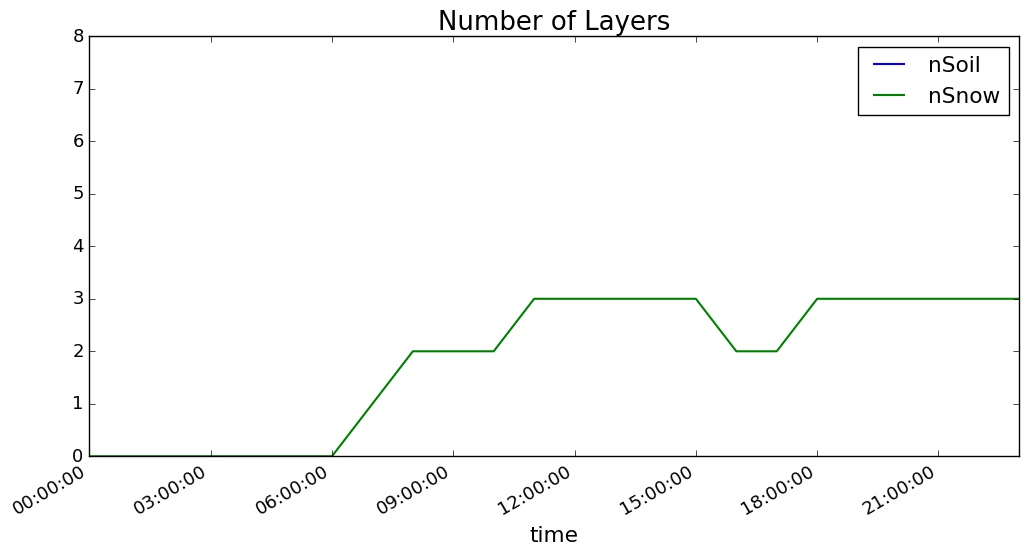

In [6]:
sp.plot_curve(['nSoil','nSnow'], title='Number of Layers')

### dual Y axises

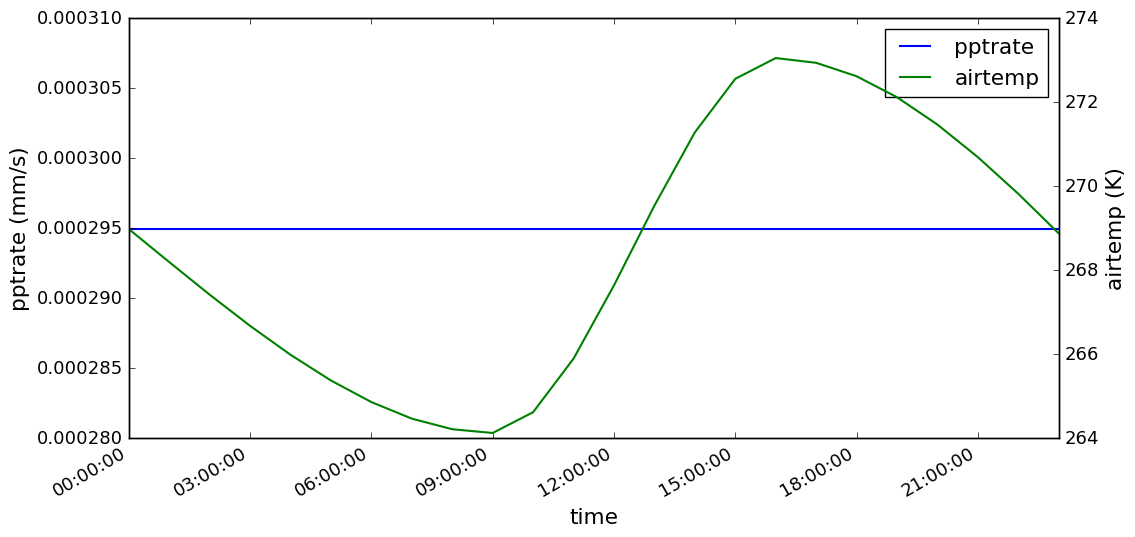

In [7]:
sp.plot_curve(['pptrate','airtemp'], secondary_y=['airtemp'], ylab='pptrate (mm/s)', rylab='airtemp (K)')

### plot data across several output files

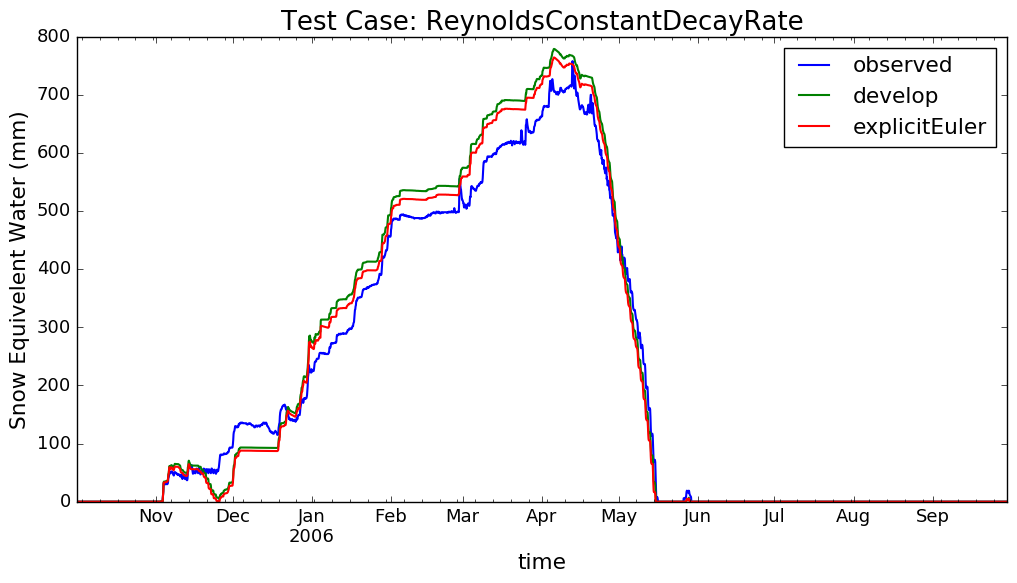

In [8]:
ds_obs = xr.open_dataset(r'D:\Cloud\Dropbox\postdoc\summa\summaTestCases\testCases_data_org\validationData\ReynoldsCreek_valData.nc')
ds_dep = xr.open_dataset(r'D:\Cloud\Dropbox\postdoc\summa\summaData\summaTestCases\output_develop\wrrPaperTestCases\figure06\albedoTest_2005-2006_reynoldsConstantDecayRate_1.nc')
ds_exp = xr.open_dataset(r'D:\Cloud\Dropbox\postdoc\summa\summaData\summaTestCases\output_explicitEuler\wrrPaperTestCases\figure06\albedoTest_2005-2006_reynoldsConstantDecayRate_1.nc')

for k in ds_dep.data_vars.keys(): ds_dep.rename({k: 'dep_' + k}, inplace=True)
for k in ds_exp.data_vars.keys(): ds_exp.rename({k: 'exp_' + k}, inplace=True)

ds_all = xr.merge([ds_obs['SWE'], ds_dep['dep_scalarSWE'], ds_exp['exp_scalarSWE']], join='inner')
sp = SummaPlot(ds_all)
ax = sp.plot_curve(['SWE','dep_scalarSWE','exp_scalarSWE'], 
                   title='Test Case: ReynoldsConstantDecayRate', 
                   ylab='Snow Equivelent Water (mm)', 
                   new_name=['observed','develop', 'explicitEuler'])

### plot profile alomg time

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


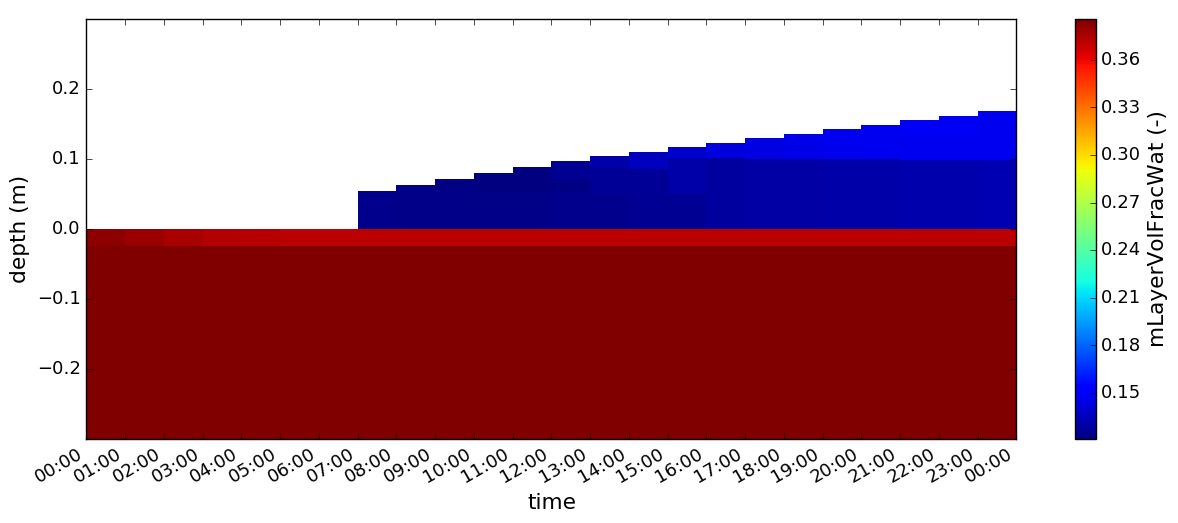

In [9]:
ds_all = xr.open_dataset(r"D:\Cloud\Dropbox\postdoc\summa\summaData\problematicHRU\snow_too_low\columbia_snow_too_low_spinup_1.nc")
sp = SummaPlot(ds_all)
sp.plot_column('mLayerVolFracWat', ylim=(-0.3, 0.3), figsize=(15, 6))

### add annotation to profile plot

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


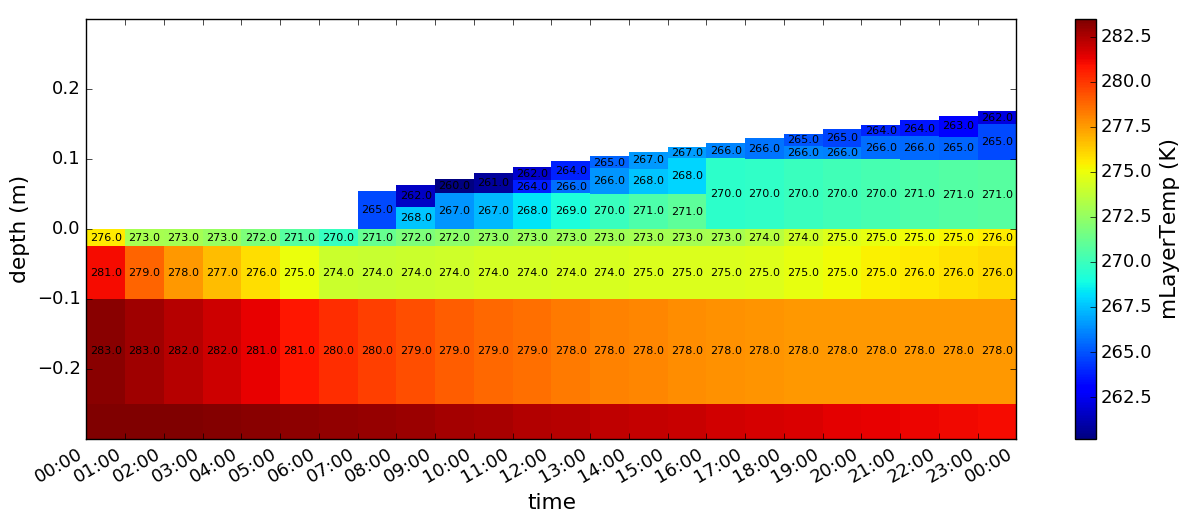

In [10]:
sp.plot_column('mLayerTemp', ylim=(-0.3, 0.3), figsize=(15, 6),  annotate=True, decimals=0)

### Multiple profile plot

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


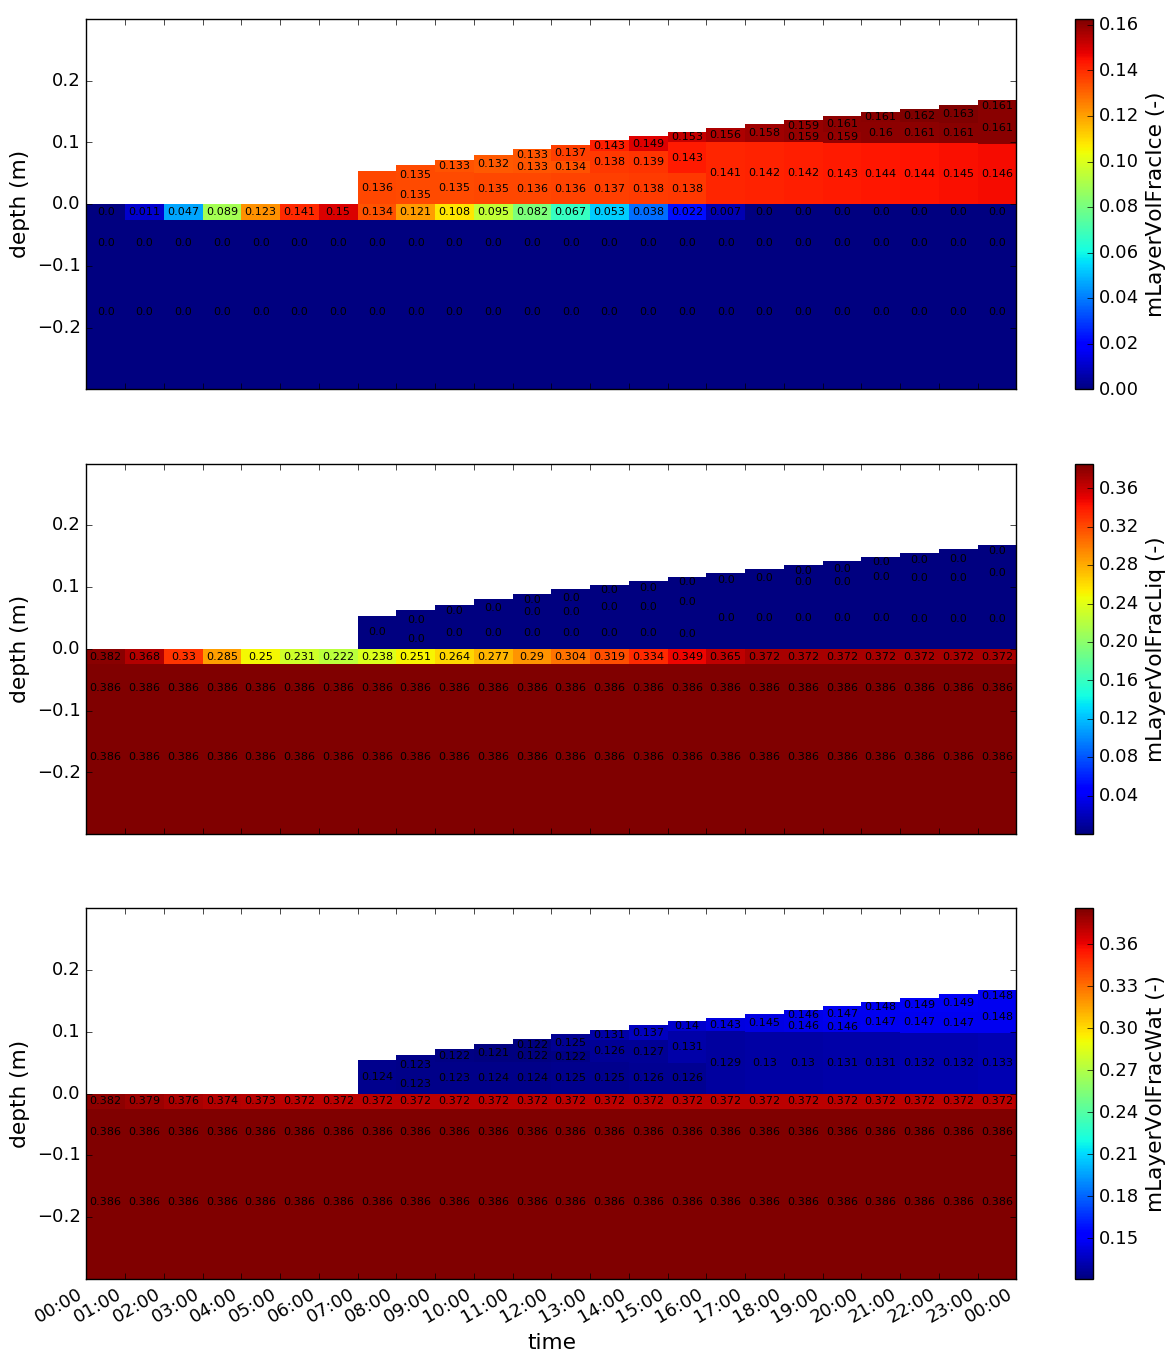

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(15, 18))
sp.plot_column('mLayerVolFracIce', ylim = (-0.3, 0.3), ax=ax[0], legend=True, annotate=True)
sp.plot_column('mLayerVolFracLiq', ylim = (-0.3, 0.3), ax=ax[1], legend=True, annotate=True)
sp.plot_column('mLayerVolFracWat', ylim = (-0.3, 0.3), ax=ax[2], legend=True, annotate=True)

### plot profiles along HRUs

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


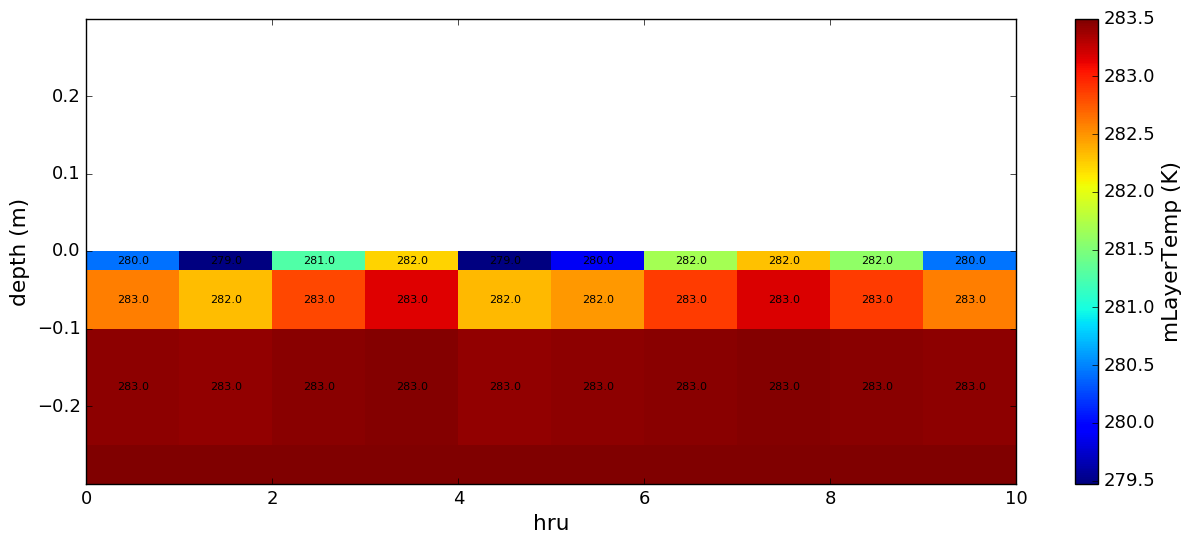

In [12]:
ds_all = xr.open_dataset(r"D:\Cloud\Dropbox\postdoc\summa\summaData\columbia10\Outputs\columbia_test_spinup_1.nc")
sp = SummaPlot(ds_all)
sp.plot_column('mLayerTemp', x_axis='hru', ylim=(-0.3, 0.3), figsize=(15, 6),  annotate=True, decimals=0)

### fast map plot

Wall time: 168 ms


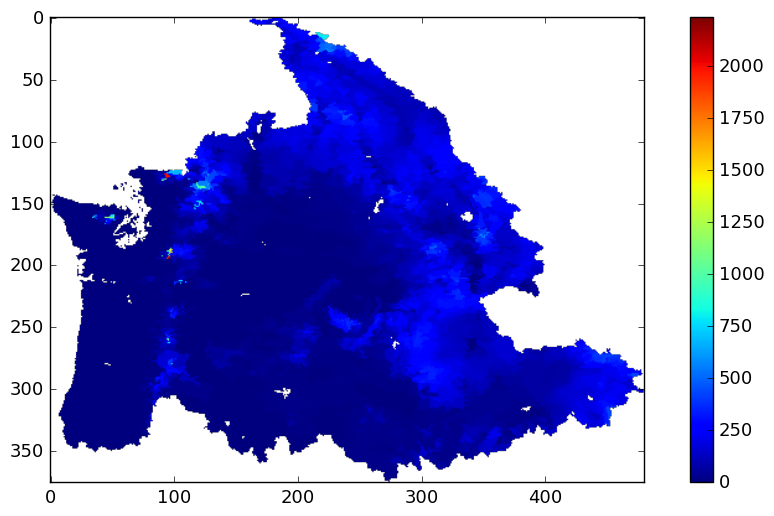

In [13]:
var_name = 'scalarSWE_mean'
ds_all = xr.open_dataset(r'D:\Cloud\Dropbox\postdoc\summa\summaData\columbia_full_run\monthlySWE.nc')
idx_grid = r'D:\Cloud\Dropbox\postdoc\summa\columbia\data\hru_idx.tif'
sp = SummaPlot(ds_all)
%time sp.plot2d_fast_map(var_name, idx_grid, val_range=[0,9999])

### full map plot (based on HRU polygon) 

Wall time: 3min 4s


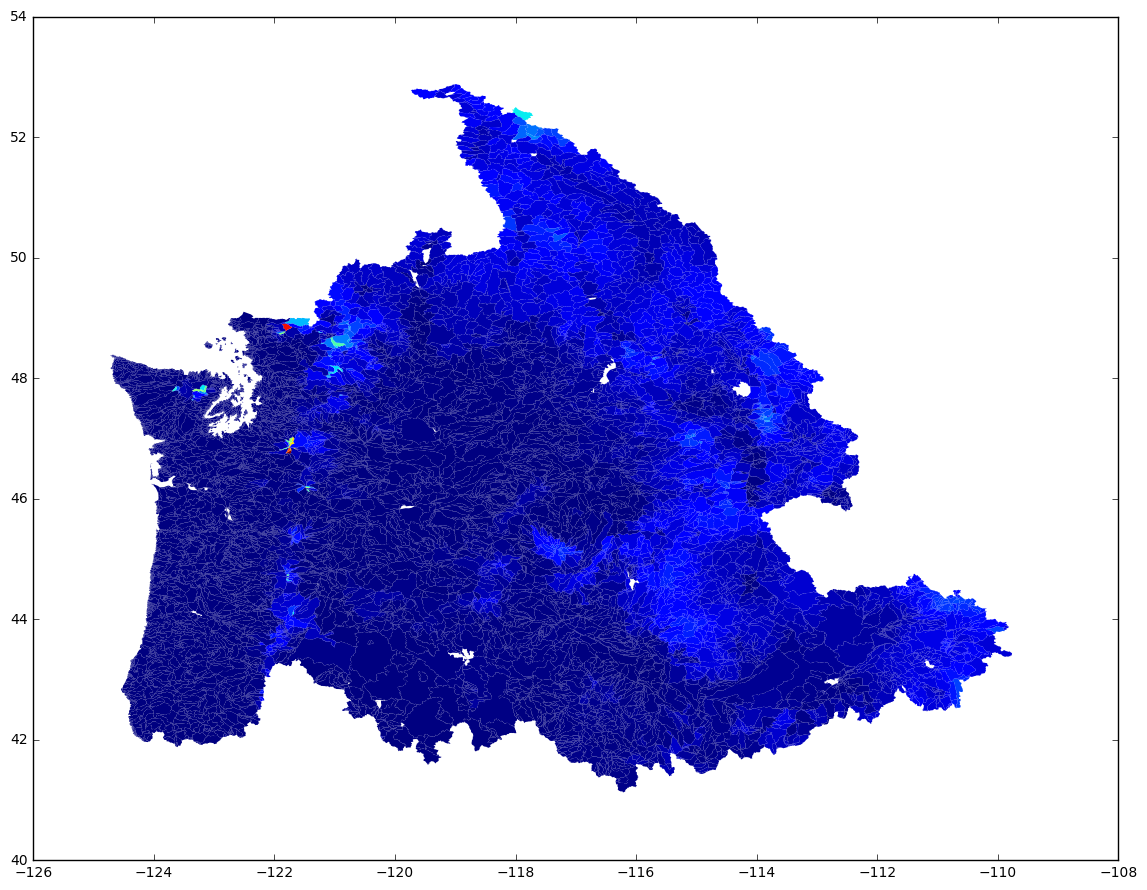

In [25]:
var_name = 'scalarSWE_mean'
ds_all = xr.open_dataset(r'D:\Cloud\Dropbox\postdoc\summa\summaData\columbia_full_run\monthlySWE.nc')
hrushp = gpd.GeoDataFrame.from_file(r'D:\Cloud\Dropbox\postdoc\summa\columbia\data\columbia_hru_output_geo.shp')
sp = SummaPlot(ds_all)
%time sp.plot2d_map(var_name, hrushp, val_range=[0,9999], figsize=(14,14))

### make it prettier

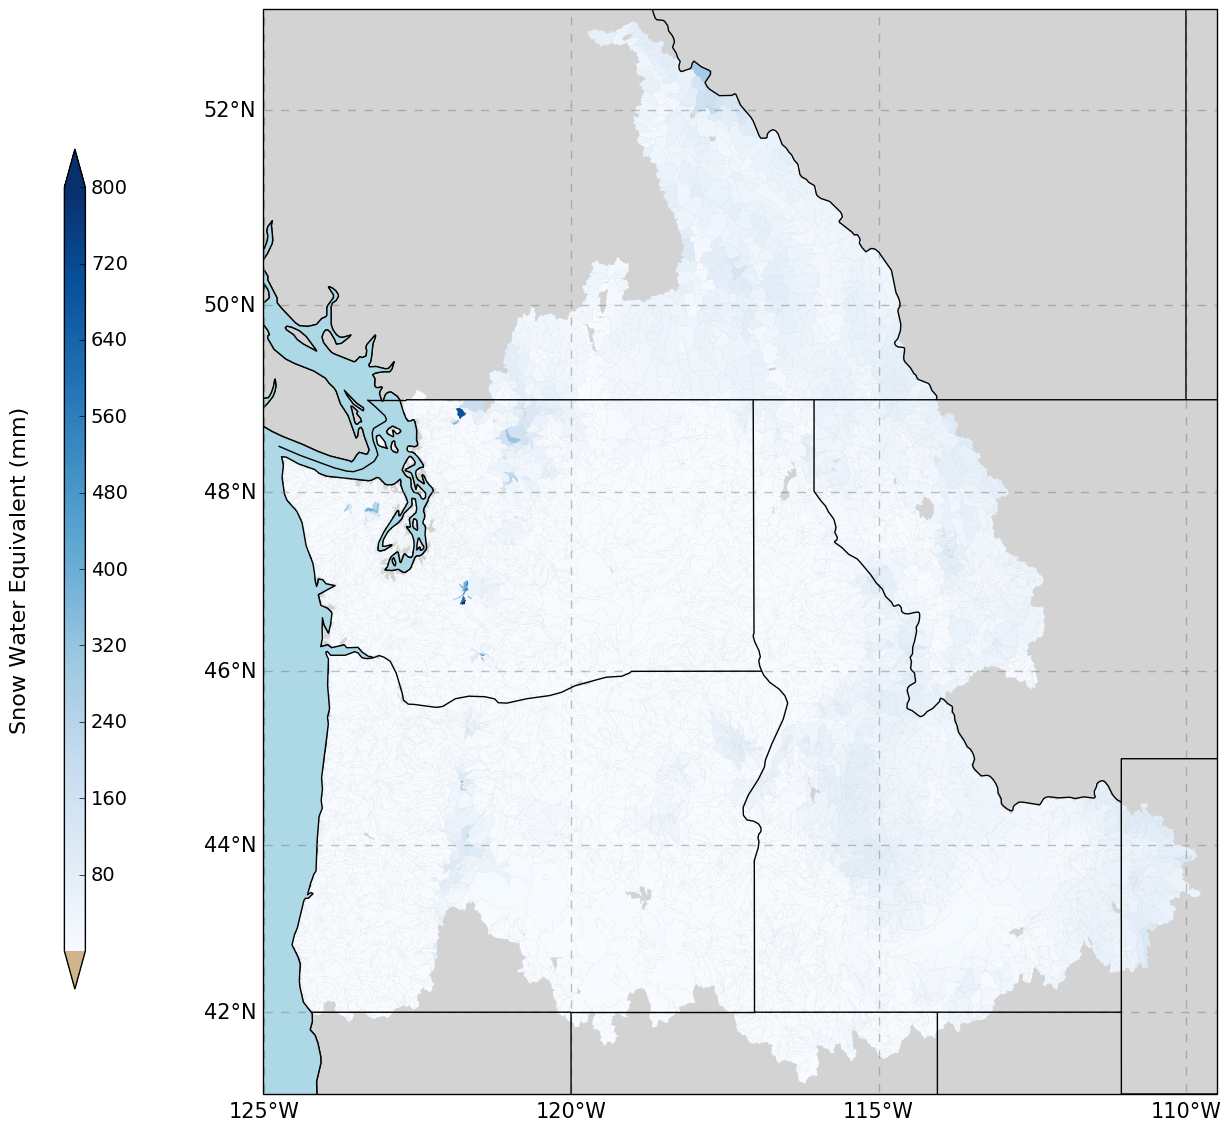

In [27]:

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def add_gridlines(ax ,labelsize=15):
    gl=ax.gridlines(draw_labels=True, 
                    xlocs = [-100, -110, -115, -120, -125], 
                    ylocs = [40, 42, 44, 46, 48, 50, 52, 54],
                    linewidth=1, color='gray', alpha=0.5, linestyle='--')
                    
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': labelsize}
    gl.ylabel_style = {'size': labelsize}
    return ax

# see this how to change backgroud color: http://stackoverflow.com/questions/32200438/change-the-background-colour-of-a-projected-matplotlib-axis
def add_map_features(ax, states_provinces=True, country_borders=True, land=True, ocean=True, lake=False):
    if states_provinces==True:
        states_provinces = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale='50m',
                facecolor='none')
        ax.add_feature(states_provinces, edgecolor='black', zorder = 2) #linewidth = 2

    if country_borders==True:
        country_borders = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_0_boundary_lines_land',
                scale='50m',
                facecolor='none')
        ax.add_feature(country_borders, edgecolor='black', zorder = 2, linewidth = 1)

    if land==True:
        land = cfeature.NaturalEarthFeature(
            category='physical',
            name='land',
            scale='50m',
            facecolor='gray')
        ax.add_feature(land,facecolor='lightgray', zorder = 0)

    if ocean==True:
        ocean = cfeature.NaturalEarthFeature(
            category='physical',
            name='ocean',
            scale='50m',
            facecolor='blue')
        ax.add_feature(ocean,facecolor='lightblue', zorder = 1)
        
    if lake==True:
        rivers_lakes = cfeature.NaturalEarthFeature(
            category='physical',
            name='rivers_lake_centerlines',
            scale='50m',
            facecolor='none')
        ax.add_feature(rivers_lakes,facecolor='lightblue', zorder = 2)
    
    return ax
        
vmin=0.01
vmax=800.0
swe_cmap=plt.get_cmap('Blues')
swe_cmap.set_under(color='tan')

norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)


# define projection
crs = ccrs.Mercator(central_longitude=-120, min_latitude=40, max_latitude=53, globe=None)
hrushp.to_crs(crs=crs.proj4_params,inplace=True)  # this step is very important! otherwise, the shapefile will not plot correctly in the figure

# start plotting
fig = plt.figure(figsize=(14,14))
ax  = plt.axes(projection=crs) 
## define the coordinate limits
ax.set_extent([-125.01, -109.5, 41, 53], ccrs.Geodetic())    
## add grid line
ax = add_gridlines(ax)
## add base map features
ax = add_map_features(ax)    
## plot hru
sp = SummaPlot(ds_all)
sp.plot2d_map(var_name, hrushp, cmap=swe_cmap, ax=ax, val_range=[0,9999],idx_other=11)
#hrushp.plot(ax=ax, linewidth=0.0, alpha=1.0, zorder=999)
#gdf_basin.plot(ax=ax, linewidth=0.0, alpha=1.0, zorder=999)

cbar_ax_abs = fig.add_axes([0.03, 0.2, 0.015, 0.6])
cbar_ax_abs.tick_params(labelsize=14)
cbar_abs = mpl.colorbar.ColorbarBase(cbar_ax_abs, cmap=swe_cmap, norm=norm, extend='both').set_label(label='Snow Water Equivalent (mm)', size=16, labelpad=-85)